## Open the file

In [1]:
import pandas as pd
file = "C:\\Users\\Ramachandraiah\\Downloads\\un-general-debates-blueprint (1).csv"
df = pd.read_csv(file)
df.head(20)

case_id case_outcome                                         case_title  \
0    Case1        cited  Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...   
1    Case2        cited  Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...   
2    Case3        cited  Colgate Palmolive Co v Cussons Pty Ltd (1993) ...   
3    Case4        cited  Dais Studio Pty Ltd v Bullett Creative Pty Ltd...   
4    Case5        cited  Dr Martens Australia Pty Ltd v Figgins Holding...   
5    Case6        cited  GEC Marconi Systems Pty Ltd v BHP Information ...   
6    Case7        cited  John S Hayes &amp; Associates Pty Ltd v Kimber...   
7    Case8        cited  Seven Network Limited v News Limited (2007) 24...   
8    Case9      applied  Australian Broadcasting Corporation v O'Neill ...   
9   Case10     followed  Hexal Australia Pty Ltd v Roche Therapeutics I...   
10  Case11        cited  Castlemaine Tooheys Ltd v South Australia [198...   
11  Case12        cited  R v McFarlane; Ex parte O'Flannagan and O'Kell...   
12  Case13     followed  National Australia Bank v KDS Construction Ser...   
13  Case14     followed         George v Cluning (1979) 53 ALJR 767 (note)   
14  Case15     followed  Australian Mid-Eastern Club Limited v Yassim (...   
15  Case16     followed  Deputy Commissioner of Taxation v Visidet Pty ...   
16  Case17     followed  Deputy Commissioner of Taxation v Guy Holdings...   
17  Case19        cited  Motor Terms Co Pty Ltd v Liberty Insurance Ltd...   
18  Case21  referred to  Appellant S395/2002 v Minister for Immigration...   
19  Case22        cited  Minister for Immigration and Multicultural Aff...   

                                            case_text  
0   Ordinarily that discretion will be exercised s...  
1   The general principles governing the exercise ...  
2   Ordinarily that discretion will be exercised s...  
3   The general principles governing the exercise ...  
4   The preceding general principles inform the ex...  
5   I accept that the making of a rolled up offer ...  
6   The preceding general principles inform the ex...  
7   On the question of the level of unreasonablene...  
8   recent decision of the High Court in Australia...  
9   Hexal Australia Pty Ltd v Roche Therapeutics I...  
10  Hexal Australia Pty Ltd v Roche Therapeutics I...  
11  quia timet proceedings, the court will have re...  
12  It was not suggested in this proceeding that, ...  
13  Strictly speaking, a cheque, even a bank chequ...  
14  None of this is to suggest that the Deputy Com...  
15  None of this is to suggest that the Deputy Com...  
16  The true position is that the applicant's stat...  
17  Assuming that the Deputy Commissioner ought pr...  
18  am satisfied that the finding of the third Tri...  
19  is plain that, where an order is set aside, an...

## Look at a couple of texts

In [2]:
print(repr(df.iloc[2666]["case_text"][0:400]))
print(repr(df.iloc[4726]["case_text"][0:400])) 

'I agree with the contention that the Trustee did fail properly to apply cl 27(g) of the Trust Deed. It is clear that it had a discretion as to whether to appoint Public Trustee or some other person to be trustee for the SST benefit: see cl 27(g)(ii). It does not appear to have exercised that discretion, because it has said in its letter of 25 October 2006 that it simply applied a rule or policy wi'
'SZMNP v Minister for Immigration and Citizenship [2009] FCA 596 at [38] , Jacobson J referred to there being " some tension in the authorities as to what use, if any, can be made of the Tribunal\'s written reasons in determining whether s 424A(1)(a) was enlivened ". His Honour accepted that in light of the decision in SZBYR " the question is to be determined in advance of, and independently from, t'


In [3]:
# Replace missing values with an empty string
df["case_text"] = df["case_text"].fillna("")
import re
df["paragraphs"] = df["case_text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

In [4]:
!pip install spacy

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
# Convert stop words set to a list
stopwords_list = list(stopwords)
# Initialize TfidfVectorizer with the list of stop words
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords_list, min_df=5, max_df=0.7)

# Fit and transform the text data
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['case_text'])
tfidf_text_vectors.shape

C:\Users\himav\.anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(24985, 22883)

## Make a data frame of sentences

In [6]:
# flatten the paragraphs keeping the case_outcome
paragraph_df = pd.DataFrame([
    { "case_text": paragraph, "case_outcome": case_outcome }
    for paragraphs, case_outcome in zip(df["paragraphs"], df["case_outcome"])
    for paragraph in paragraphs if paragraph])
paragraph_df.head(10)  

case_text case_outcome
0  Ordinarily that discretion will be exercised s...        cited
1  The general principles governing the exercise ...        cited
2  Ordinarily that discretion will be exercised s...        cited
3  The general principles governing the exercise ...        cited
4  The preceding general principles inform the ex...        cited
5  I accept that the making of a rolled up offer ...        cited
6  The preceding general principles inform the ex...        cited
7  On the question of the level of unreasonablene...        cited
8  recent decision of the High Court in Australia...      applied
9  Hexal Australia Pty Ltd v Roche Therapeutics I...     followed

## Get the TFIDF of the sentences DF

In [7]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words='english',
    min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["case_text"])
tfidf_para_vectors.shape

(24809, 22877)

## Non-negative Matrix Factorization (NMF)

In [8]:
from sklearn.decomposition import NMF

In [9]:
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

C:\Users\himav\.anaconda\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## Getting our 10 topics

In [10]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
    for i in range(0, no_top_words):
        print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))
        display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())

In [11]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# Example usage:
#display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())
display_topics(nmf_text_model,tfidf_text_vectorizer.get_feature_names_out())


Topic 00
 act (0.44)
 trade (0.41)
 conduct (0.41)
 mr (0.39)
 mark (0.38)

Topic 01
 tribunal (4.79)
 appellant (2.67)
 decision (1.33)
 information (0.87)
 review (0.85)

Topic 02
 minister (4.24)
 immigration (4.11)
 multicultural (3.76)
 affairs (3.74)
 indigenous (2.69)

Topic 03
 court (2.37)
 appeal (1.49)
 federal (1.07)
 application (0.92)
 leave (0.81)

Topic 04
 ltd (2.78)
 pty (2.33)
 fca (0.92)
 australia (0.67)
 fcr (0.59)

Topic 05
 privilege (2.70)
 documents (1.58)
 legal (1.56)
 advice (1.46)
 awb (1.45)

Topic 06
 costs (4.26)
 party (1.60)
 order (1.51)
 indemnity (0.91)
 security (0.75)

Topic 07
 clr (1.50)
 hca (1.44)
 commissioner (1.13)
 taxation (0.84)
 cj (0.50)

Topic 08
 respondent (1.71)
 austlii (1.59)
 au (1.58)
 date (1.53)
 policy (1.50)

Topic 09
 native (3.25)
 title (3.12)
 group (1.70)
 claim (1.18)
 land (1.09)


In [12]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
 mark (0.41)
 trade (0.39)
 mr (0.39)
 evidence (0.37)
 act (0.36)

Topic 01
 tribunal (4.73)
 appellant (2.64)
 decision (1.33)
 review (0.84)
 information (0.84)

Topic 02
 minister (4.27)
 immigration (4.15)
 multicultural (3.80)
 affairs (3.77)
 indigenous (2.72)

Topic 03
 respondent (1.71)
 austlii (1.60)
 au (1.59)
 date (1.53)
 policy (1.51)

Topic 04
 court (2.33)
 appeal (1.44)
 federal (1.04)
 application (0.90)
 leave (0.79)

Topic 05
 privilege (2.71)
 documents (1.57)
 legal (1.56)
 advice (1.46)
 awb (1.45)

Topic 06
 costs (4.11)
 party (1.55)
 order (1.46)
 indemnity (0.89)
 security (0.74)

Topic 07
 native (3.33)
 title (3.19)
 group (1.73)
 claim (1.18)
 land (1.11)

Topic 08
 clr (1.49)
 hca (1.44)
 commissioner (1.09)
 taxation (0.81)
 cj (0.49)

Topic 09
 pty (1.99)
 commission (1.10)
 fca (1.02)
 australian (0.94)
 competition (0.82)


In [13]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.70275604, 11.84405752,  9.57721315, 12.90362808, 14.49526743,
        5.10372872,  7.83748787, 12.14134286,  8.29684162,  6.09767672])

In [14]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([11.18642767, 11.67623966,  9.61429101,  7.33656272, 15.99415304,
        5.7800826 ,  7.79136099,  5.7273124 , 13.36837523, 11.52519468])

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words='english', min_df=5,
max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["case_text"])
count_para_vectors.shape



(24809, 22877)

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
lda_para_model = LatentDirichletAllocation(n_components = 10,
random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words='english',
min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["case_text"])
count_para_vectors.shape

(24809, 22877)

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

## Define and fit the LDA model

In [19]:
lda_para_model = LatentDirichletAllocation(n_components = 10,
random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

## Start by cutting the paragraphs into words:

In [20]:
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic %d:" % (topic_idx + 1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get feature names from the vocabulary generated by CountVectorizer
feature_names = count_para_vectorizer.get_feature_names_out()

# Display topics using the vocabulary generated by CountVectorizer
display_topics(lda_para_model, feature_names)


Topic 1:
court decision case act power

Topic 2:
pty court contract act conduct

Topic 3:
privilege awb legal documents advice

Topic 4:
mr company income case agreement

Topic 5:
act conduct commission person australian

Topic 6:
pty court evidence trade law

Topic 7:
title native trade mark use

Topic 8:
tribunal minister decision appellant immigration

Topic 9:
court costs order mr respondent

Topic 10:
commissioner clr hca pty taxation


In [21]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([16.02529492,  8.78432733,  2.04814464,  8.5663055 , 11.66876139,
        7.53120331,  8.14267926, 18.2857544 , 11.69900263,  7.24852664])

## Draw wordclouds for the 10 topics

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, HTML

display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

## The NMF wordclouds:

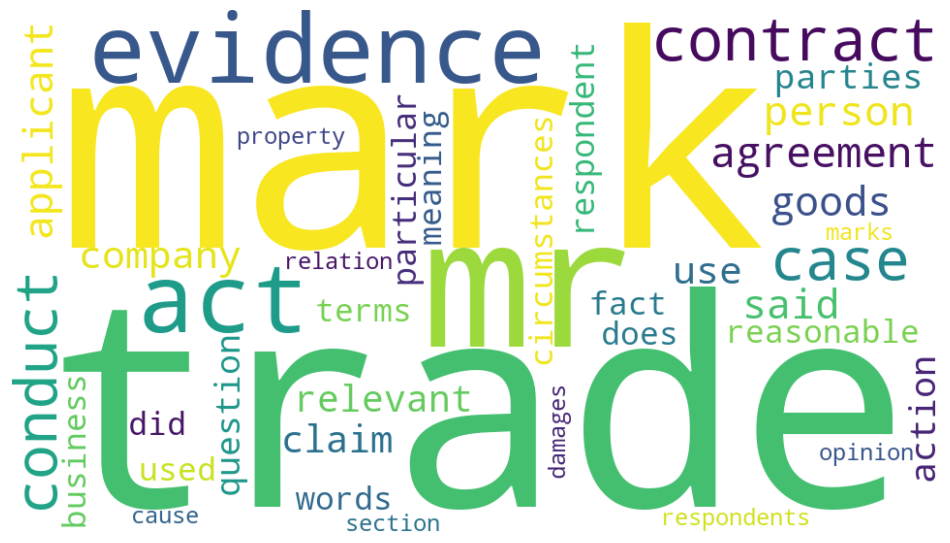

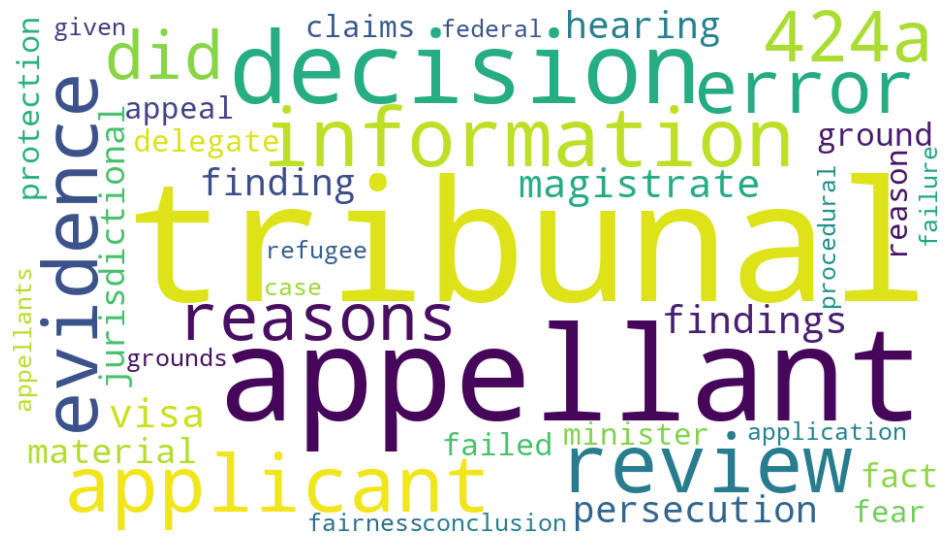

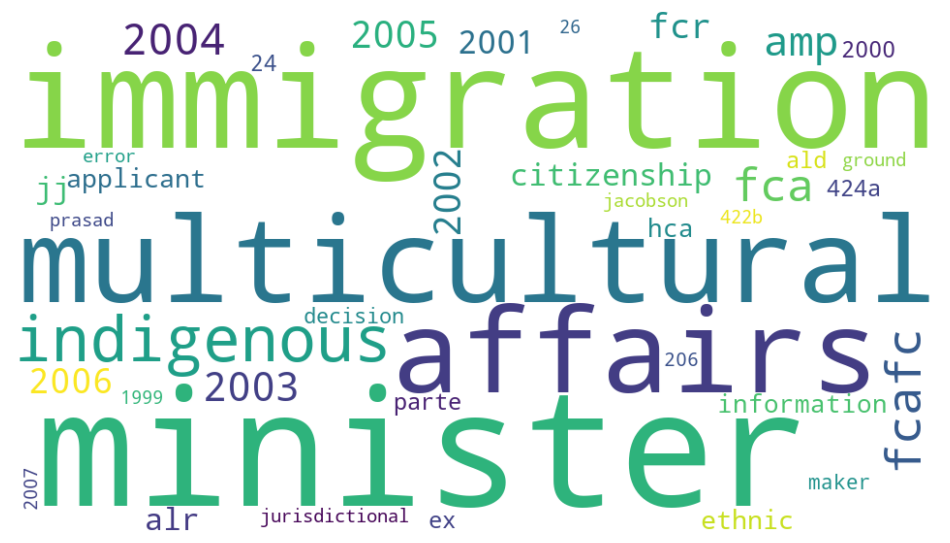

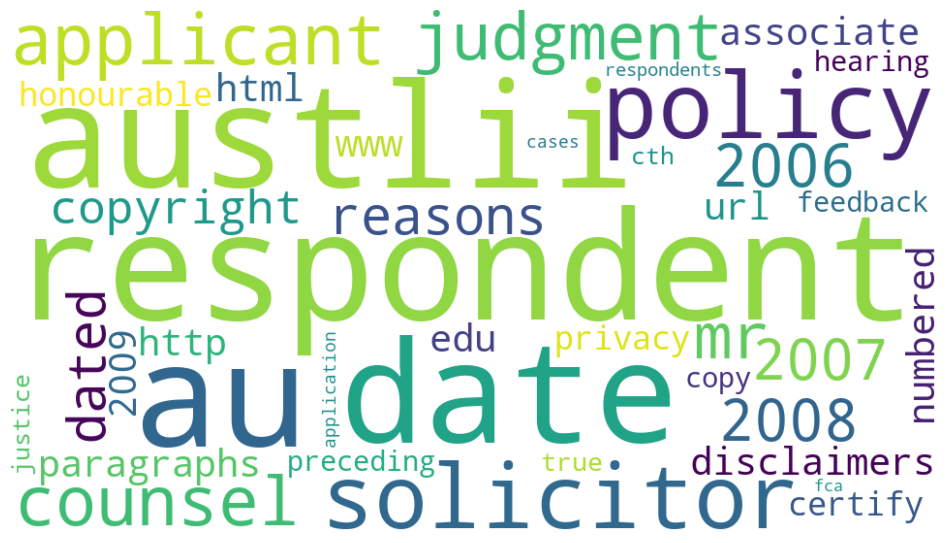

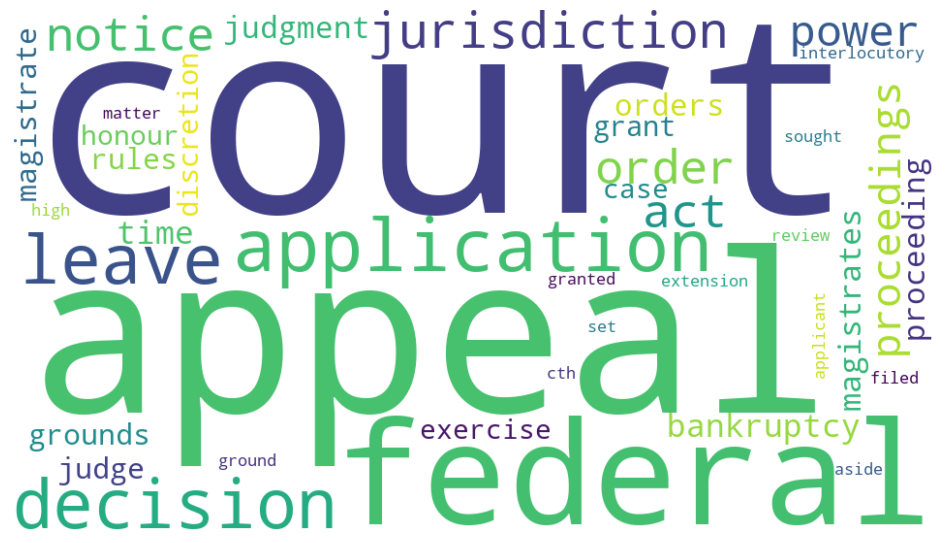

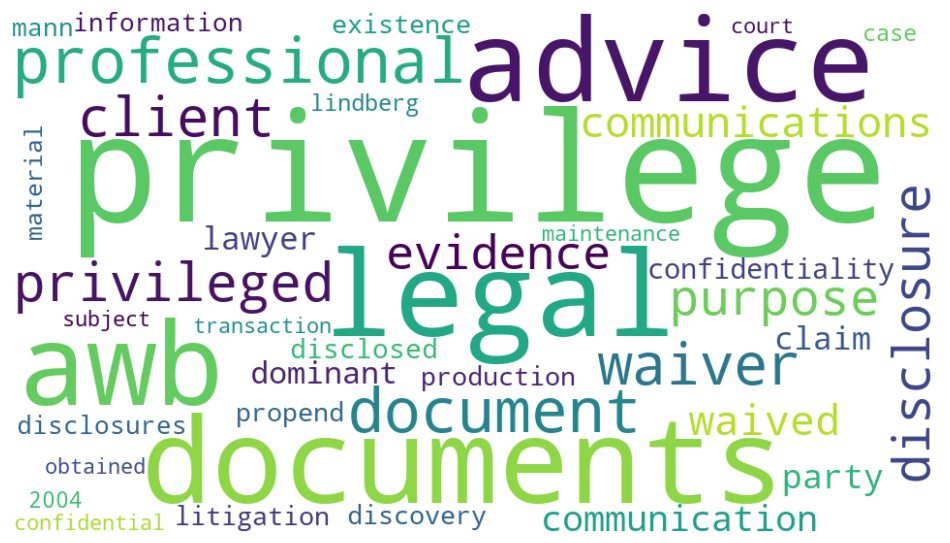

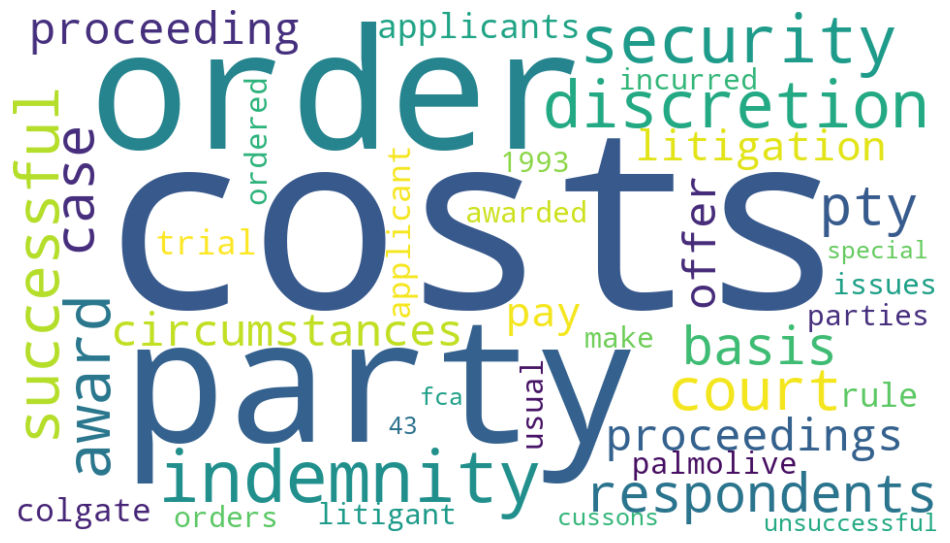

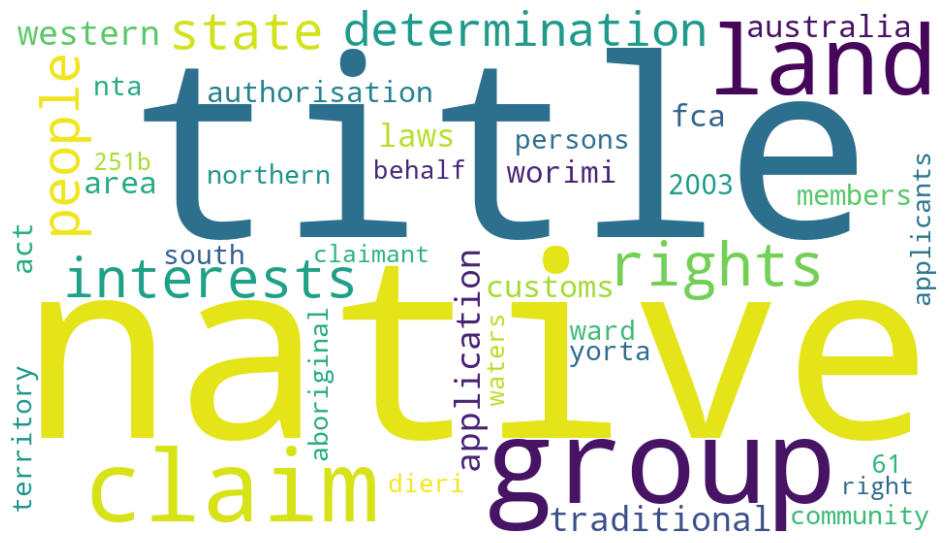

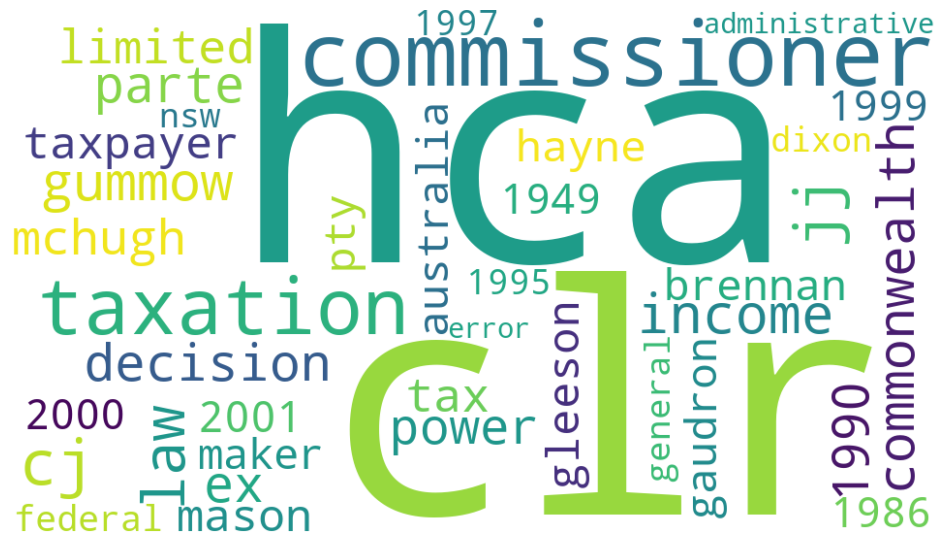

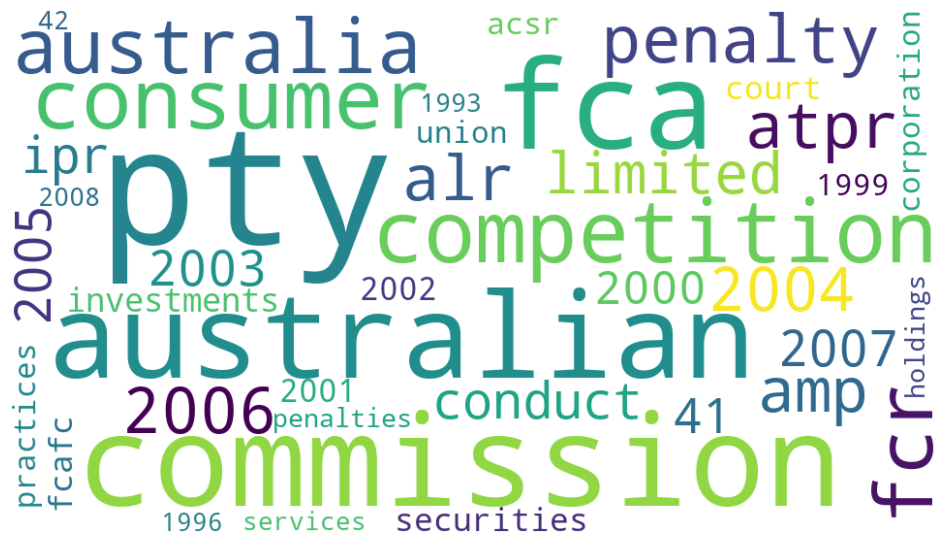

In [23]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

## The LDA wordclouds

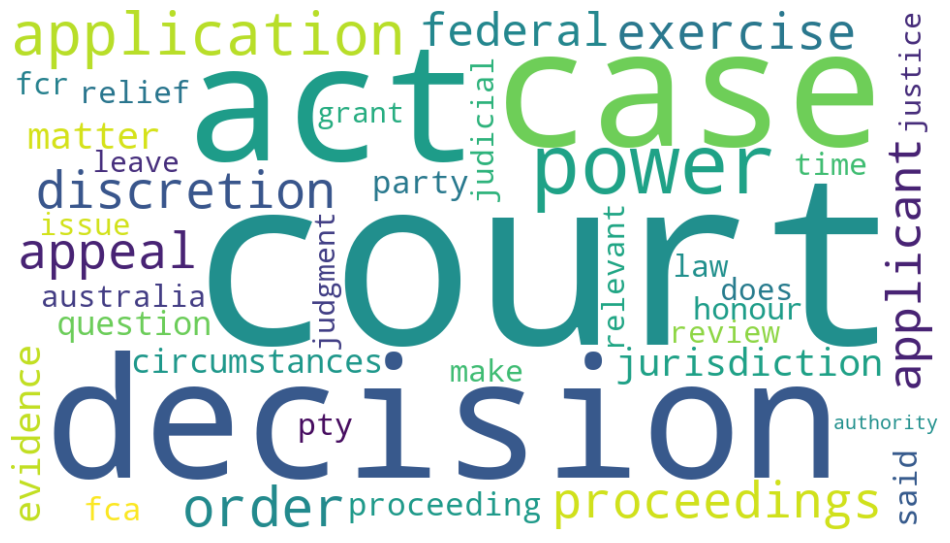

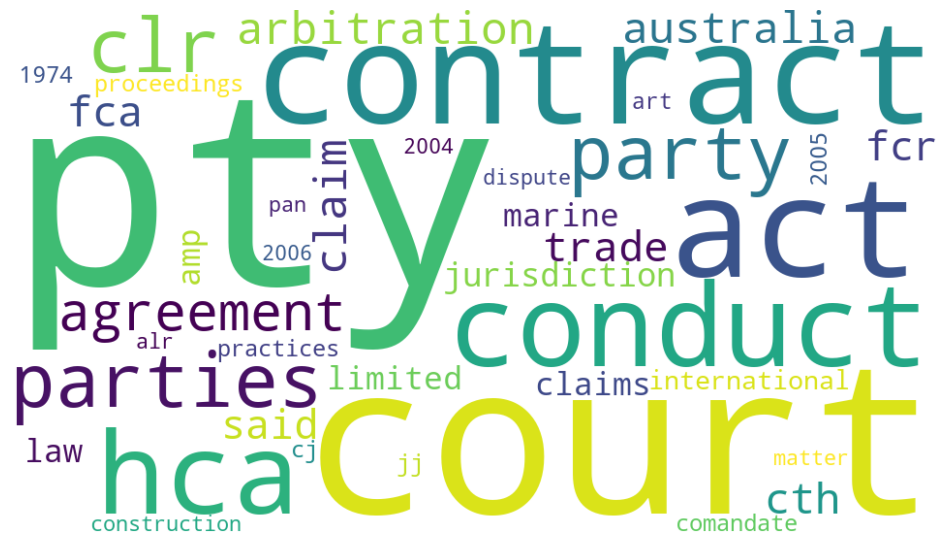

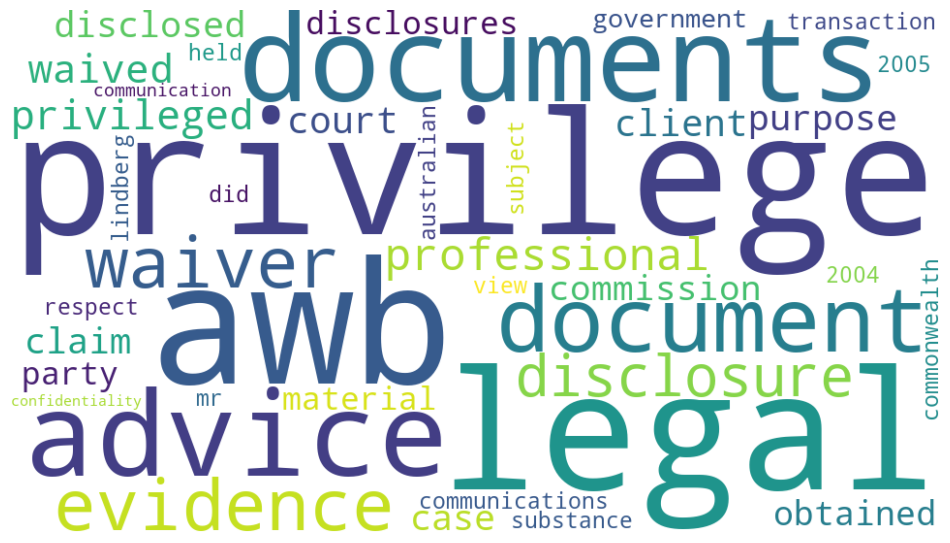

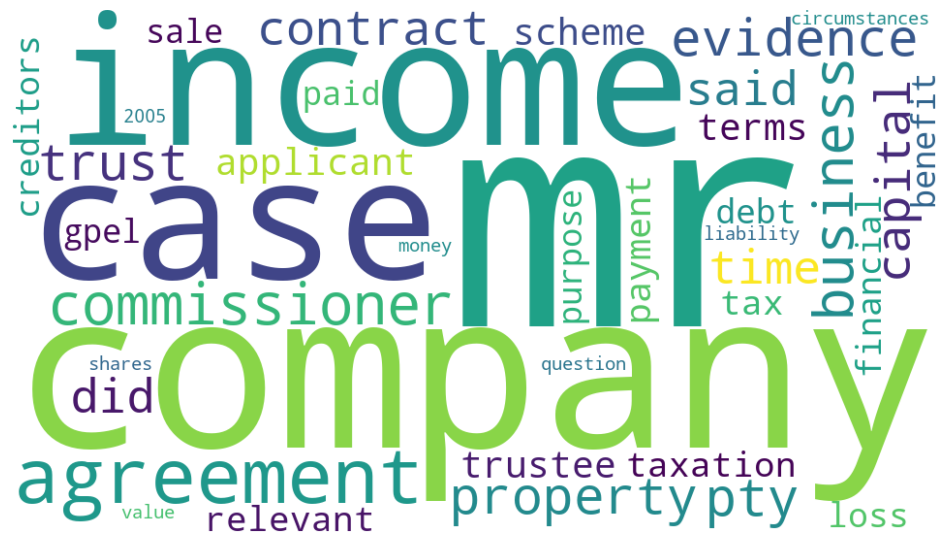

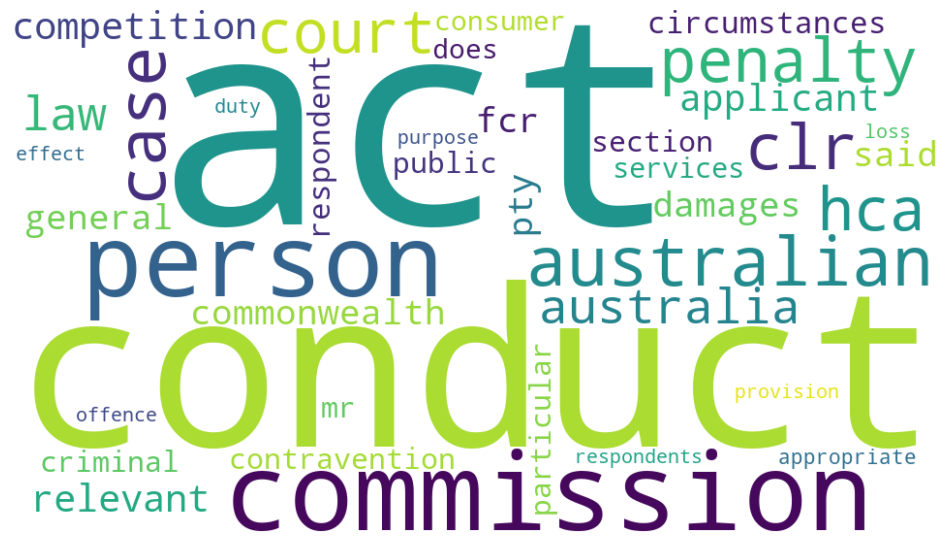

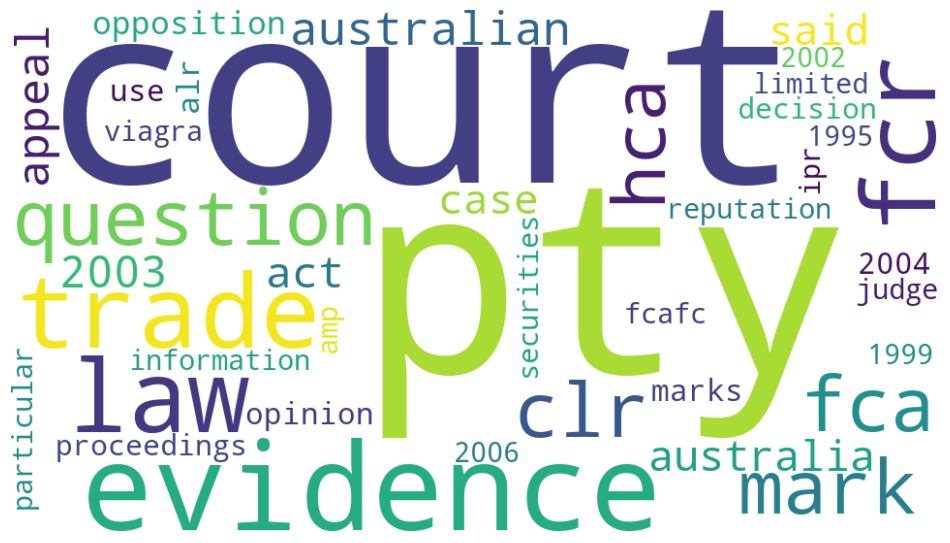

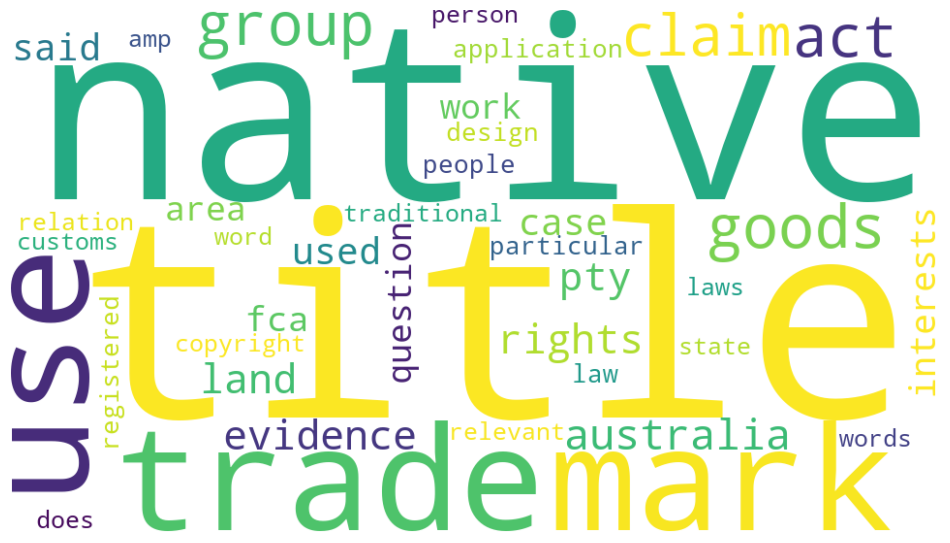

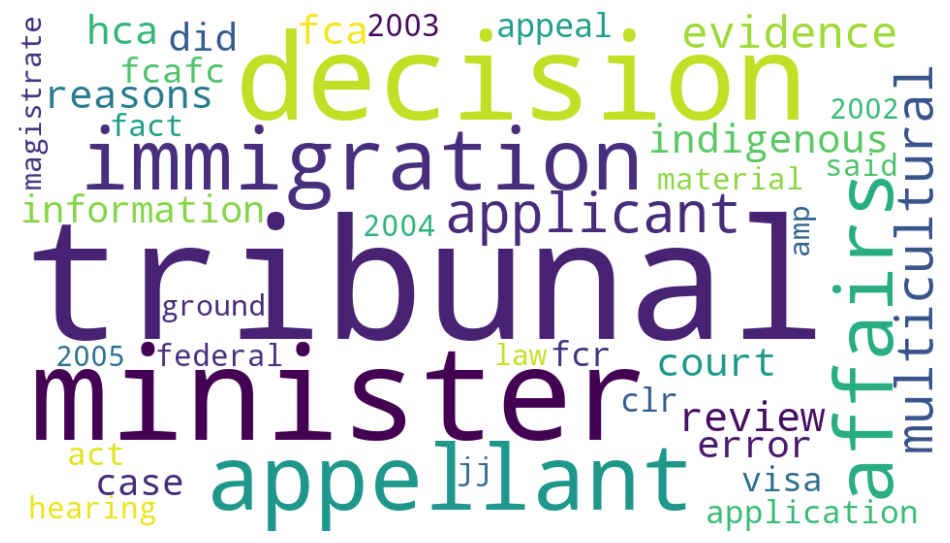

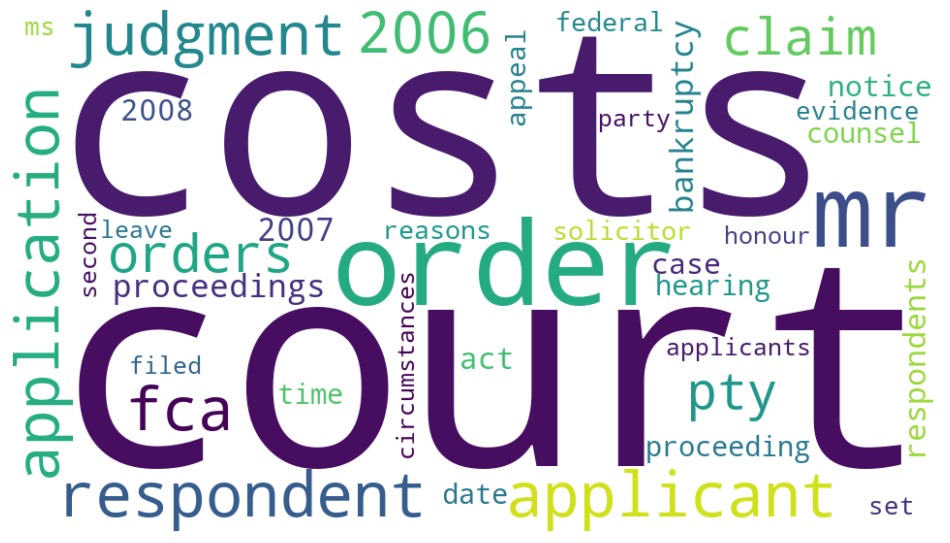

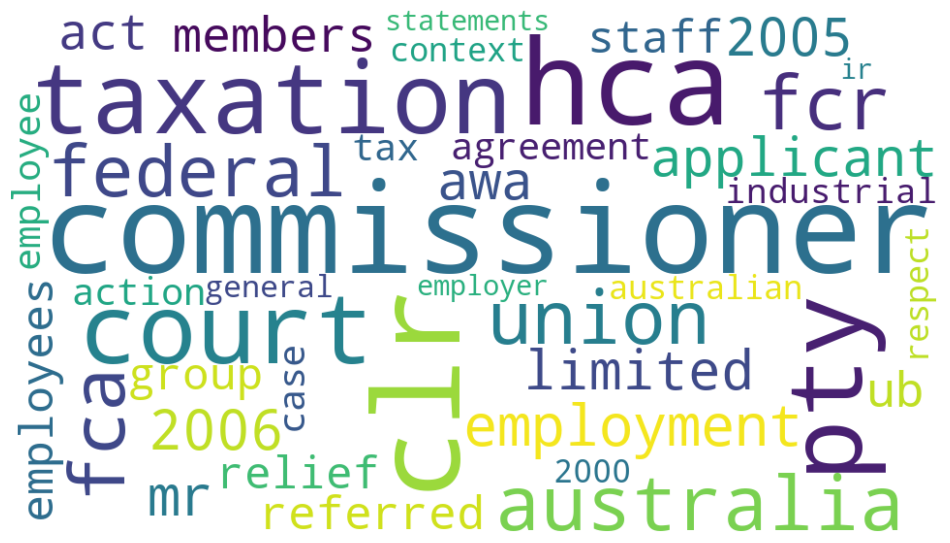

In [24]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

In [25]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

## Separate data by year

In [26]:
from tqdm.auto import tqdm
import numpy as np

outcome_data = []

unique_outcome = np.unique(paragraph_df["case_outcome"])

for outcome in tqdm(unique_outcome):
    outcome_indices = np.array(paragraph_df["case_outcome"] == outcome)
    if np.any(outcome_indices):  # Check if there are samples available for the current year
        W_outcome = nmf_para_model.transform(tfidf_para_vectors[outcome_indices])
        outcome_data.append([outcome] + list(np.sum(W_outcome, axis=0) / np.sum(W_outcome) * 100.0))

  0%|          | 0/10 [00:00<?, ?it/s]

## Draw time chart

<Axes: xlabel='price'>

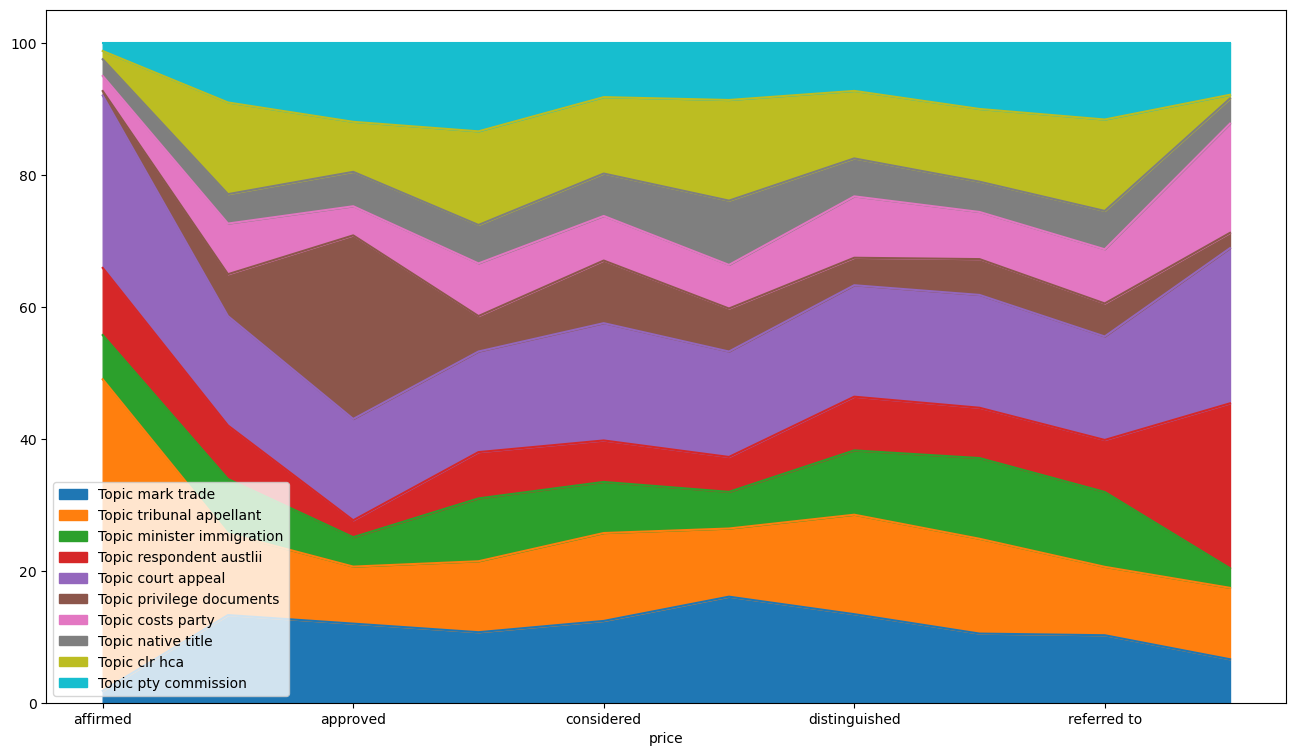

In [27]:
import matplotlib.pyplot as plt
df_outcome = pd.DataFrame(outcome_data, columns=["price"] +
topic_names).set_index("price")
df_outcome.plot.area(figsize=(16,9))